In [1]:
import jax.numpy as jnp
import jax
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.append('../')
from field_level.forward_model import Forward_Model
import field_level.coord as coord
import field_level.cosmo_util as cosmo_util
import field_level.power_util as power_util

jax.config.update('jax_enable_x64', True)
jax.config.update("jax_disable_jit", True)  ### save memory though it becomes slow

### Generate a shifted (by Zeldovich) field realization with the effective cubic bias in redshift space

In [9]:
model_name = '1lpt_matter_rsd_cubic'
#model_name = '1lpt_matter_rsd_lin'
#model_name = '1lpt_lin'
#model_name = 'gauss_rsd'

which_pk = 'cosmo'
#ng = 384
ng = 256
ng_L = int(1.5*ng)
ng_E = 256
ng_params = [ng, ng_L, ng_E]

boxsize = 2000.0

kf = 2.*jnp.pi/boxsize
kny = jnp.pi/boxsize*ng
kny_E = jnp.pi/boxsize*ng_E

which_space = 'k_space' ### currently no effect
window_order = 3 ### TSC
interlace = 1 ### interlace on
mas_params = [window_order, interlace]

model = Forward_Model(model_name, which_pk, ng_params, boxsize, which_space, mas_params=mas_params)

model =  1lpt_matter_rsd_cubic


In [10]:
### prepare the kvec that is used to generate the field-level model
### here kmax determines the maximun wavenumber for the transfer function (relevant only for the cubic model)

kmax = kny*1.1
print('kmax = ', kmax)
model.kvecs(kmax)

kmax =  0.44233624562544294


In [11]:
### get the linear matter power spectrum from JAX-CosmoPower

redshift = 0.5

omega_b = 0.02242 ### Omega_b h^2
omega_c = 0.11933 ### Omega_cdm h^2
hubble = 0.73
ns = 0.9665
ln1010As = 3.047 
OM0 = (omega_c + omega_b)/hubble/hubble

growth_f = cosmo_util.growth_f_fitting(redshift, OM0)
print('growth_f = ', growth_f)

cosmo_params = [omega_b, 
                omega_c,
                hubble,
                ns,
                ln1010As,
                0.0]   ### for the sigma8 computation

pk_lin = model.linear_power(cosmo_params)
sigma8 = model.sigma8(pk_lin)
print('sigma8 =', sigma8)
cosmo_params[-1] = redshift
pk_lin = model.linear_power(cosmo_params)



growth_f =  0.7175181128407132
sigma8 = 0.8350423924781689


In [12]:
### generate the linear modes
### first generate random gaussian variables with ng^3  

seed = 1995
np.random.seed(seed)
ng3 = ng**3
gauss_1d = np.random.normal(size=ng3)
gauss_3d = coord.gauss_1d_to_3d(gauss_1d, ng)
deltak_lin = model.linear_modes(cosmo_params, gauss_3d)

Text(0, 0.5, '$P(k)~[(\\mathrm{Mpc}/h)^3]$')

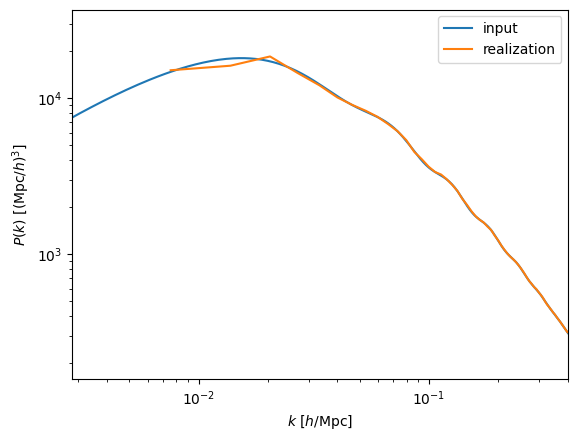

In [13]:
### check the linear power spectrum

pk = power_util.power_compute(deltak_lin, deltak_lin,
                              boxsize, kmin=kf, kmax=kny)

plt.plot(pk_lin[0], pk_lin[1], label='input')
plt.plot(pk[0], pk[1].real, label='realization')


plt.xscale('log')
plt.yscale('log')
plt.xlim(kf*0.9, kny)
plt.ylim(jnp.nanmin(pk[1].real)*0.5, jnp.nanmax(pk[1].real)*2.)

plt.legend()
plt.xlabel(r'$k~[h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k)~[(\mathrm{Mpc}/h)^3]$')

In [14]:
### generate the forward-evolved field

### if model_name contains the 'matter', this bias should be interpreted as Lagrangian bias
b1 = 1.0
b2 = -0.5
bG2 = -0.5
bGamma3 = 0.5
biases = [b1, b2, bG2, bGamma3, growth_f]  ### for cubic model

deltak_L = coord.func_extend(ng_L, deltak_lin) ### zero-padding in k space

if 'cubic' in model_name:
    model.call_Zenbu(cosmo_params, kmax)
    fieldk = model.models(deltak_L, biases, pk_lin)
else:
    fieldk = model.models(deltak_L, biases)


Preparing the function to compute transfer functions...
Done.


Text(0, 0.5, '$kP(k)~[(\\mathrm{Mpc}/h)^2]$')

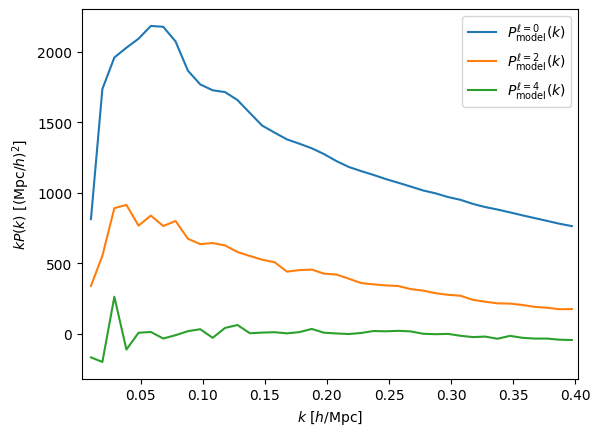

In [15]:
pk_model = []
for ell in [0, 2, 4]:
    pk_model.append(power_util.power_compute(fieldk, fieldk,
                                             boxsize,  kmin=kf, kmax=kny_E, nbin=40,
                                             ell=ell))

ell = 0
plt.plot(pk_model[ell][0], 
         pk_model[ell][0]*pk_model[ell][1].real, 
         label=r'$P^{\ell=0}_\mathrm{model}(k)$')

ell = 1
plt.plot(pk_model[ell][0], 
         pk_model[ell][0]*pk_model[ell][1].real, 
         label=r'$P^{\ell=2}_\mathrm{model}(k)$')

ell = 2
plt.plot(pk_model[ell][0], 
         pk_model[ell][0]*pk_model[ell][1].real, 
         label=r'$P^{\ell=4}_\mathrm{model}(k)$')

plt.xlim(kf*0.9, kny_E)

plt.legend()
plt.xlabel(r'$k~[h/\mathrm{Mpc}]$')
plt.ylabel(r'$kP(k)~[(\mathrm{Mpc}/h)^2]$')

Text(0, 0.5, '$kP(k)~[(\\mathrm{Mpc}/h)^2]$')

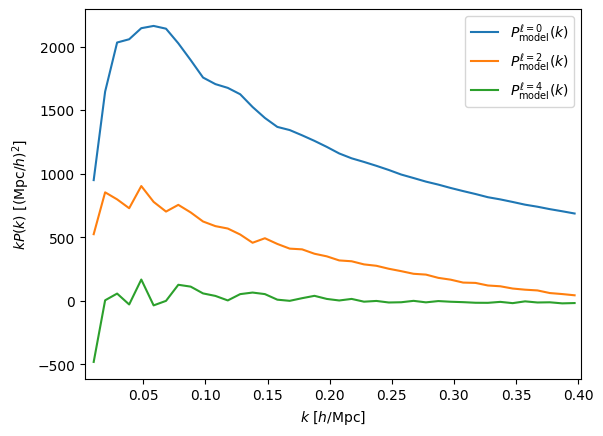

In [8]:
pk_model = []
for ell in [0, 2, 4]:
    pk_model.append(power_util.power_compute(fieldk, fieldk,
                                             boxsize,  kmin=kf, kmax=kny_E, nbin=40,
                                             ell=ell))

ell = 0
plt.plot(pk_model[ell][0], 
         pk_model[ell][0]*pk_model[ell][1].real, 
         label=r'$P^{\ell=0}_\mathrm{model}(k)$')

ell = 1
plt.plot(pk_model[ell][0], 
         pk_model[ell][0]*pk_model[ell][1].real, 
         label=r'$P^{\ell=2}_\mathrm{model}(k)$')

ell = 2
plt.plot(pk_model[ell][0], 
         pk_model[ell][0]*pk_model[ell][1].real, 
         label=r'$P^{\ell=4}_\mathrm{model}(k)$')

plt.xlim(kf*0.9, kny_E)

plt.legend()
plt.xlabel(r'$k~[h/\mathrm{Mpc}]$')
plt.ylabel(r'$kP(k)~[(\mathrm{Mpc}/h)^2]$')